In [1209]:
import pandas as pd
import spacy
import steamreviews
import json
import csv
import os
import glob
import json
import matplotlib.pyplot as plt
import nltk
import wordcloud
from wordcloud import WordCloud
import re
import plotly
import seaborn as sns
import stanza
import string 
import joblib
from scipy.stats import pearsonr


from pandas.io.json import json_normalize
from nltk.corpus import stopwords
from tqdm.notebook import trange, tqdm
from sklearn.cluster import KMeans

## Reviews download
https://pypi.org/project/steamreviews/

In [1210]:
dir_name = "data"
reviews_jsons = glob.glob(f"{dir_name}/*")
reviews_jsons

['data\\review_1150690.json',
 'data\\review_1172620.json',
 'data\\review_1341290.json',
 'data\\review_1515210.json',
 'data\\review_210970.json',
 'data\\review_219150.json',
 'data\\review_219890.json',
 'data\\review_250320.json',
 'data\\review_257510.json',
 'data\\review_262060.json',
 'data\\review_289070.json',
 'data\\review_294100.json',
 'data\\review_304430.json',
 'data\\review_394360.json',
 'data\\review_400.json',
 'data\\review_427520.json',
 'data\\review_460950.json',
 'data\\review_550.json',
 'data\\review_620.json',
 'data\\review_632470.json',
 'data\\review_646570.json',
 'data\\review_736260.json',
 'data\\review_860510.json']

In [1211]:
title_dict = {"219150": "Hotline Miami",
              "1172620" : "Sea of Thieves",
              "460950" : "Katana ZERO",
              "262060" : "Darkest Dungeon",
              "250320" : "The Wolf Among Us",
              "210970" : "The Witness",
              "620" : "Portal 2",
              "736260" : "Baba Is You",
              "219890" : "Antichamber",
              "289070" : "Sid Meier's Civilization VI",
              "427520" : "Factorio",
              "257510" : "The Talos Principle",
             "304430" : "INSIDE",
             "400" : "Portal",
             "394360" : "Hearts of Iron IV",
             "632470" : "Disco Elysium",
             "294100" : "RimWorld",
              "646570" : "Slay the Spire",
              "1150690" : "Omori",
              "1341290" : "We Were Here Forever",
              "1515210" : "The Past Within",
              "860510" : "Little Nightmares II",
              "550" : "Left 4 Dead 2"}

In [1212]:
genre_dict = {"219150": "A",
              "1172620" : "A",
              "460950" : "A",
              "262060" : "R",
              "250320" : "R",
              "210970" : "P",
              "620" : "P",
              "736260" : "P",
              "219890" : "P",
              "289070" : "S",
              "427520" : "S",
              "257510" : "P",
              "304430" : "P",
             "400" : "P",
             "394360" : "S",
             "632470" : "R",
             "294100" : "S",
             "646570" : "R",
             "1150690" : "R",
             "1341290" : "P",
             "1515210" : "P",
             "860510" : "P",
             "550" : "A"}

In [1213]:
data_list = []
for i in reviews_jsons:
    with open(i, encoding = "utf-8") as json_file:
        json_data = json.load(json_file)
        reviews = json_data['reviews']
        file_name = json_file.name.split('.')[0].split('_')[1]
        for key in reviews.keys():
            data_list.append([title_dict.get(file_name),genre_dict.get(file_name),reviews[key]['author']['steamid'], reviews[key]['votes_up'], 
                          reviews[key]['review'], reviews[key]['weighted_vote_score'], reviews[key]['voted_up'],
                          reviews[key]['author']['num_games_owned'], reviews[key]['author']['playtime_at_review'],
                          reviews[key]['author']['num_reviews'], 
                          reviews[key]["timestamp_created"] ])
df = pd.DataFrame(data_list, columns = ["title", "genre","steamid", "votes_up", "review", "weighted_vote_score", "voted_up",
                                        "num_games_owned", "playtime_at_review", "num_reviews", "timestamp_created"])

In [1214]:
df.sample(frac=0.3).head()

,title,genre,steamid,votes_up,review,weighted_vote_score,voted_up,num_games_owned,playtime_at_review,num_reviews,timestamp_created
682,Omori,R,76561199185667801,1,Omori is single-handedly one of my all time fa...,0.523809552192687988,True,116,2022,6,1689838863
27594,Portal 2,P,76561199091058317,1,Just a good game. I consider Portal 2 to be th...,0.519230782985687256,True,93,292,68,1680979881
6115,Sea of Thieves,A,76561198124784409,1188,- DIFFICULTY -\n\n🔲 My 90 year old grandma cou...,0.888225257396697998,True,0,852,5,1617732421
998,Omori,R,76561199366047236,1,Brilliant game! Very relatable and human depic...,0.523809552192687988,True,0,3703,4,1678065079
6298,We Were Here Forever,P,76561198257069227,1,Okay 6/10. Decent fun with a friend.\n\nThe pu...,0.523809552192687988,True,165,1039,43,1676093407


In [1215]:
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'], unit='s')

## Preprocessing

1. Braki danych
2. Usunięcie duplikatów
4. Usunięcie recenzjii krótszych niż 3 słowa
9. Usunięcie znaków spcjalnych 
10. "Text lowering"
6. Usunięcie znaków interpunkcyjnych i liczb
8. Usunięcie tytułów gier z recenzji
7. Tokenizacja
8. Part-of-speech tagging
9. Lematyzacja

#### Braki danych

In [1216]:
df.isna().sum()

title                  0
genre                  0
steamid                0
votes_up               0
review                 0
weighted_vote_score    0
voted_up               0
num_games_owned        0
playtime_at_review     0
num_reviews            0
timestamp_created      0
dtype: int64

#### Usunięcie duplikatów

In [1217]:
df.duplicated(subset='review').sum()

2580

In [1218]:
df[df.duplicated(subset='review')].sample(20)

,title,genre,steamid,votes_up,review,weighted_vote_score,voted_up,num_games_owned,playtime_at_review,num_reviews,timestamp_created
10357,Sid Meier's Civilization VI,S,76561198188508983,1,its ok,0.523809552192687988,True,52,60108,1,2023-07-11 18:55:08
18629,Portal,P,76561199232599777,1,yes,0.523809552192687988,True,0,301,34,2022-12-18 17:30:51
23866,Left 4 Dead 2,A,76561199124811804,1,:),0.523809552192687988,True,0,1041,2,2023-01-07 00:32:16
9712,Darkest Dungeon,R,76561198268830855,1,good,0.50152820348739624,True,197,342,88,2022-11-07 03:13:08
9549,Darkest Dungeon,R,76561198137432167,1,i hate it,0.519999980926513672,True,156,246,16,2023-08-21 12:08:51
30860,Slay the Spire,R,76561198151954461,1,yea,0.52173912525177002,True,220,1830,19,2023-07-17 23:48:05
14230,RimWorld,S,76561198071854271,1,Yes.,0.506769359111785889,True,0,6341,36,2023-08-12 13:39:38
24475,Left 4 Dead 2,A,76561198200076777,1,it ok,0.523809552192687988,True,82,1164,3,2022-10-31 22:29:19
3270,Sea of Thieves,A,76561199192200948,1,good game,0.523809552192687988,True,0,3598,1,2023-08-05 12:52:17
21275,Katana ZERO,A,76561199412294443,1,is good,0.523809552192687988,True,0,281,7,2023-07-13 16:07:55


In [1219]:
(df.duplicated(subset='review') == False).sum()

29492

In [1220]:
df = df[df.duplicated(subset='review') == False]

In [1221]:
df.duplicated(subset='review').sum()

0

#### Długość recenzji

In [1222]:
df["temp_review_len"] = df["review"].apply(lambda x: x.split(" ").__len__())
df["temp_review_len"].describe()

count    29492.000000
mean        54.191984
std        135.354534
min          1.000000
25%          5.000000
50%         13.000000
75%         39.000000
max       3997.000000
Name: temp_review_len, dtype: float64

In [1223]:
df[df["temp_review_len"] < 4].groupby(by=["genre"]).count()

,title,steamid,votes_up,review,weighted_vote_score,voted_up,num_games_owned,playtime_at_review,num_reviews,timestamp_created,temp_review_len
genre,,,,,,,,,,,
A,1659,1659,1659,1659,1659,1659,1659,1659,1659,1659,1659
P,852,852,852,852,852,852,852,852,852,852,852
R,798,798,798,798,798,798,798,798,798,798,798
S,1140,1140,1140,1140,1140,1140,1140,1140,1140,1140,1140


In [1224]:
df = df[df["temp_review_len"] >= 3]

In [1225]:
suma = 0
for i in df["temp_review_len"]:
    suma += i

In [1226]:
print("Ilość słów:", suma,
     "Ilość recenzji:", len(df["temp_review_len"]))

Ilość słów: 1593992 Ilość recenzji: 26663


In [1227]:
df = df.drop(["temp_review_len"], axis=1)

### Wordcloud

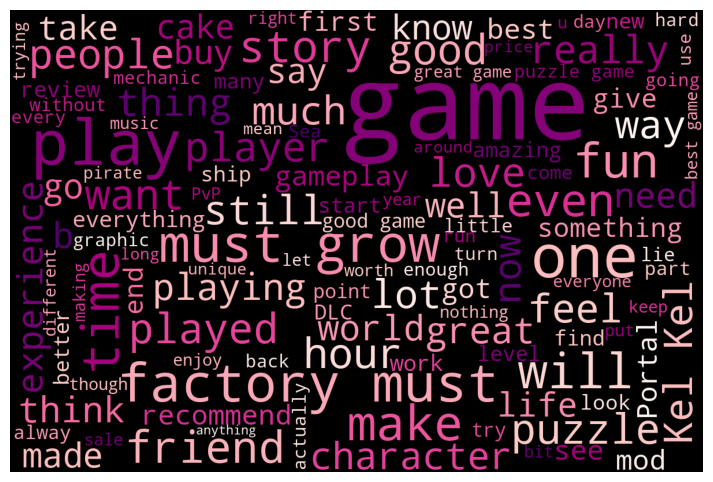

In [1228]:
txt = ' '.join(i for i in df["review"])
wordcloud = WordCloud(max_font_size = 180,
                max_words = 120,
                width = 1200,
                height = 800,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

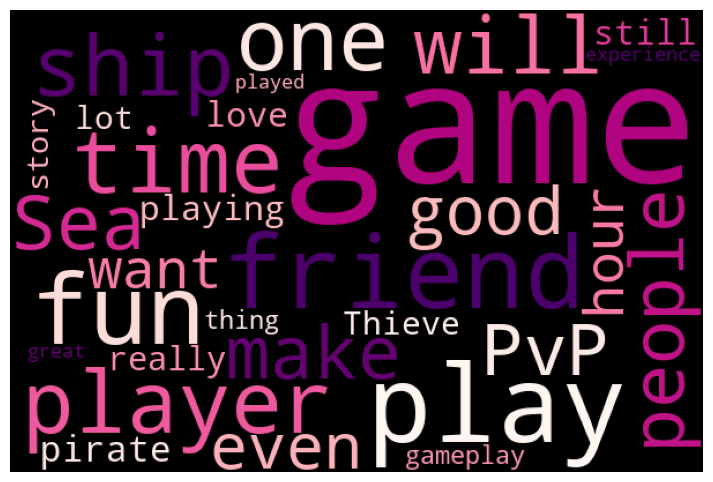

In [1229]:
txt = ' '.join(i for i in df[df['genre'] == "A"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

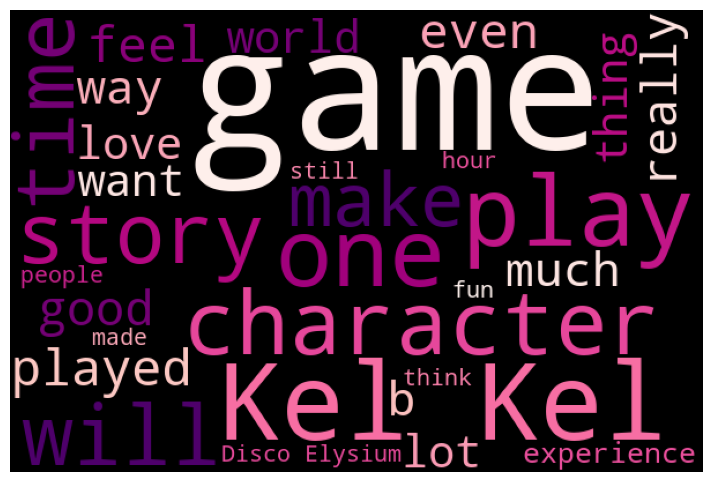

In [1230]:
txt = ' '.join(i for i in df[df['genre'] == "R"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

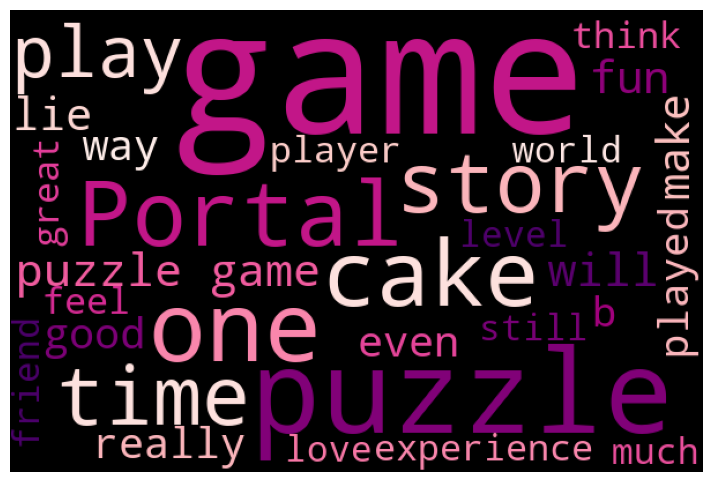

In [1231]:
txt = ' '.join(i for i in df[df['genre'] == "P"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

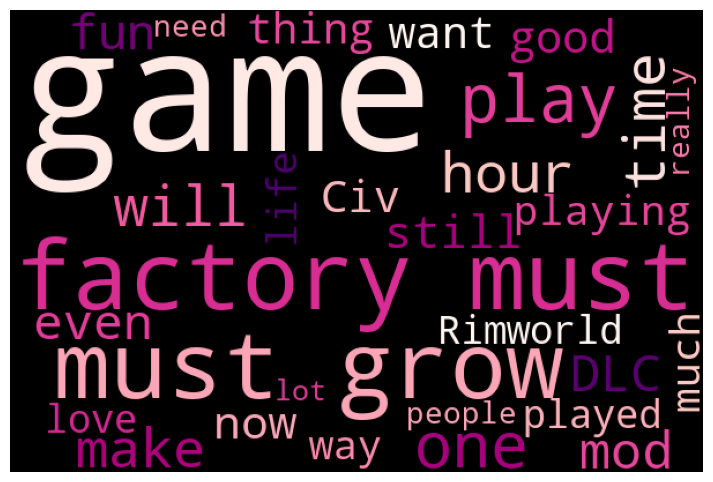

In [1232]:
txt = ' '.join(i for i in df[df['genre'] == "S"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

#### Usunięcie znaków, text lowering

In [1233]:
df["review"] = df["review"].str.replace(r"\[.*?\]|\n|[^\x00-\x7F]+", "", regex=True).str.lower()

In [1234]:
df["review"].sample(10)

7613                        pretty fricking hard but good 
17606    you can play as joseph stalinedit: hang on you...
30054                             definitely worth playing
10494    i'm not sure what the developers were trying t...
15198    war game where the combat is ass, ai wins for ...
15516    the base game itself is good, but there's so m...
20619                                   heh 1+funny number
28377    pls do not buy this  game --------------------...
26892    masterpiece that is hard to forget. the storyt...
19635                                good game i would say
Name: review, dtype: object

#### Usunięcie znaków interpunkcyjnych i liczb

In [1235]:
df["review"] = df["review"].str.replace(r"[0-9]", "", regex=True)

In [1236]:
df["review"] = df["review"].str.replace('['  + string.punctuation + ']', "", regex =True)

In [1237]:
df["review"].sample(5)

6193               amazing game play with someone you love
8062      when the game is on sale for  its hard to say no
6450     fantastic entry in the series much longer stor...
3611                               i caught my first fish 
10285    id meiers civilization vi is a strategic maste...
Name: review, dtype: object

#### Usunięcie tytułów gier z recenzji

In [1238]:
for value in title_dict.values():
    df["review"] = df["review"].str.replace(value.lower(), "")

#### Tokenizacja

In [1239]:
df["tokenized"] = df["review"].apply(nltk.word_tokenize)

In [1240]:
df["tokenized"].sample(15)

19409    [its, a, neat, game, but, i, can, not, support...
3620     [one, day, you, make, millions, of, gold, conq...
5393     [game, barely, functions, and, it, has, a, lot...
5333     [make, a, funny, comment, on, one, of, their, ...
12846    [eternally, exciting, and, frustrating, and, i...
16874    [dlc, in, this, game, is, so, ridiculously, ex...
11316    [as, a, mostly, singleplayer, civ, enjoyer, i,...
28755    [took, me, tries, to, get, into, this, game, b...
25576    [it, was, the, best, of, times, it, was, the, ...
29627                   [psychological, and, good, at, it]
27279    [probably, one, of, the, best, games, i, have,...
1335     [this, is, my, favorite, game, of, all, time, ...
31598        [baba, is, cutebrain, is, meltgame, is, pain]
25874                    [its, like, but, with, one, more]
23612     [a, classic, game, fun, for, the, whole, family]
Name: tokenized, dtype: object

### Stopwords

In [1241]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
english_stopwords = stopwords.words('english')
english_stopwords_cleaned = [word.replace("'", "") for word in english_stopwords]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [1242]:
new_column = []
for row in df["tokenized"]:
    new_row = [word for word in row if word[0] not in english_stopwords_cleaned]
    new_column.append(new_row)
df["final_review"] = new_column

## Describe

In [1243]:
df.dtypes

title                          object
genre                          object
steamid                        object
votes_up                        int64
review                         object
weighted_vote_score            object
voted_up                         bool
num_games_owned                 int64
playtime_at_review              int64
num_reviews                     int64
timestamp_created      datetime64[ns]
tokenized                      object
final_review                   object
dtype: object

In [1244]:
df["weighted_vote_score"] = pd.to_numeric(df["weighted_vote_score"])

In [1245]:
df["voted_up"] = pd.to_numeric(df["voted_up"])

In [1246]:
df.describe()

,votes_up,weighted_vote_score,num_games_owned,playtime_at_review,num_reviews
count,26663.000000,26663.000000,26663.000000,2.666300e+04,26663.000000
mean,31.715148,0.570098,140.866707,1.309372e+04,21.467689
std,173.097223,0.109932,538.652824,4.720263e+04,59.809381
min,0.000000,0.500000,0.000000,5.000000e+00,1.000000
25%,1.000000,0.521739,0.000000,5.350000e+02,3.000000
50%,1.000000,0.523810,0.000000,1.800000e+03,8.000000
75%,3.000000,0.545180,113.000000,7.111500e+03,20.000000
max,9568.000000,0.987843,22780.000000,1.890626e+06,3419.000000


C:\Users\marty\AppData\Local\Temp\ipykernel_18532\2852639080.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr(method = "pearson")


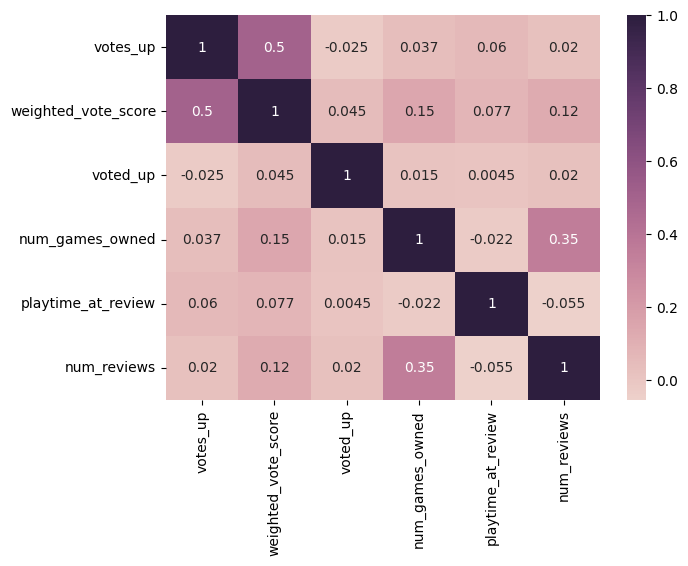

In [1247]:
corr = df.corr(method = "pearson")
plt.figure(figsize=(7,5))
sns.heatmap(corr, cmap=sns.cubehelix_palette(as_cmap=True),annot=True)
plt.show()

## Wykresy

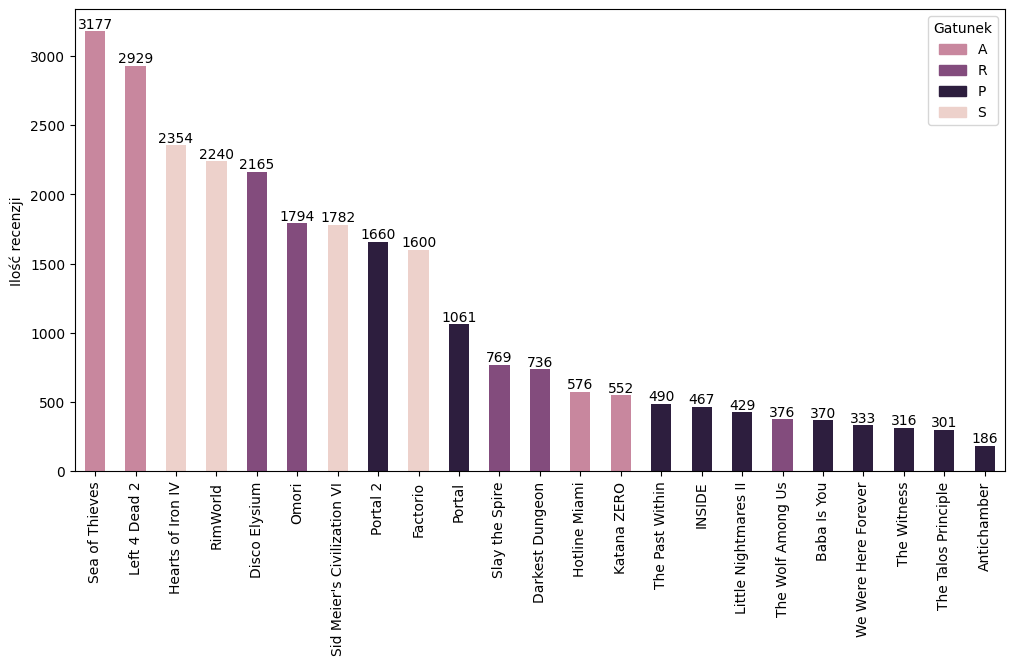

In [1248]:
value_counts_title = df["title"].value_counts()
genre_colors = {"A": sns.cubehelix_palette(4)[1], "R": sns.cubehelix_palette(4)[2], "P": sns.cubehelix_palette(4)[3], 
                "S": sns.cubehelix_palette(4)[0]}
df['color'] = df['genre'].map(genre_colors)
colors = [df.loc[df['title'] == title]['color'].iloc[0] for title in value_counts_title.index]

plt.figure(figsize=(12, 6))
x = value_counts_title.plot(kind = "bar", color = colors)
plt.ylabel("Ilość recenzji")
plt.xticks(rotation = 90)
for i, count in enumerate(value_counts_title):
    x.text(i, count, count, va = "bottom", ha = "center")

handles = [plt.Rectangle((0,0), 1,1, color=genre_colors[label]) for label in genre_colors]
plt.legend(handles, genre_colors.keys(), title="Gatunek", loc="upper right")


plt.show()
df = df.drop(["color"], axis=1)

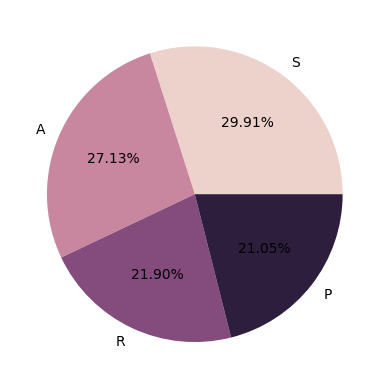

In [1249]:
value_counts_genre = df["genre"].value_counts()
colors = sns.cubehelix_palette(4)
x = plt.pie(value_counts_genre, labels = value_counts_genre.index, colors=colors, autopct='%1.2f%%')
plt.show()

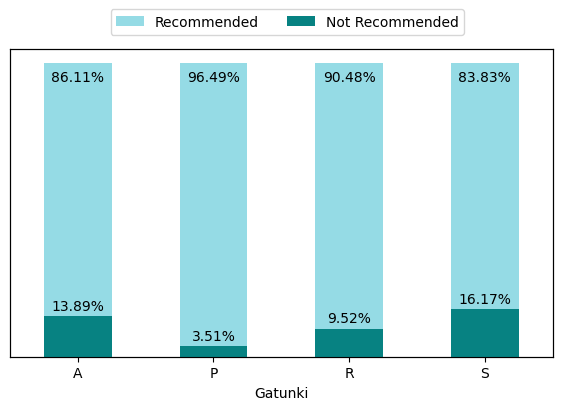

In [1250]:
value_counts_recommendation_genre = df.groupby('genre').voted_up.value_counts().unstack(0)
percentage_pos = value_counts_recommendation_genre.iloc[1] / (value_counts_recommendation_genre.iloc[1] + value_counts_recommendation_genre.iloc[0]) * 100 
percentage_neg = value_counts_recommendation_genre.iloc[0] / (value_counts_recommendation_genre.iloc[0] + value_counts_recommendation_genre.iloc[1]) * 100 

total_count = percentage_pos + percentage_neg

def addlabels_neg(x,y):
    for i in range(len(y)):
        plt.text(i, x[i] + 2, f"{x[i]:.2f}%",  ha = "center")

def addlabels_pos(x,y):
    for i in range(len(y)):
        plt.text(i, x[i] - 6, f"{y[i]:.2f}%",  ha = "center")

fig, ax1 = plt.subplots(figsize=(7, 4))
ax2 = ax1.twinx()

total_count.plot(kind="bar", color="#95DBE5FF",  label="Recommended")
percentage_neg.plot(kind="bar", color="#078282FF", label="Not Recommended")

ax1.set_xlabel("Gatunki")
ax1.tick_params(axis="y", left=False, labelleft=False)
ax2.tick_params(axis="y", right=False, labelright=False)

addlabels_neg(percentage_neg, total_count) 
addlabels_pos(total_count, percentage_pos) 

plt.legend(bbox_to_anchor=(0.85, 1.15), ncol=2)
plt.show()

## Dependency parser test

In [1251]:
test = [df["final_review"][6543], df["final_review"][4534], df["final_review"][12345], df["final_review"][12354],
        df["final_review"][1925], df["final_review"][1067],df["final_review"][22951],df["final_review"][2231],
       ["not","fun", "gameplay"], df["tokenized"][832], df["final_review"][21], df["tokenized"][27061],
       df["final_review"][11088], df["final_review"][3171], df["final_review"][7834], df["final_review"][20180],
       df["final_review"][6697], df["final_review"][893]]

In [1252]:
import stanza
nlp = stanza.Pipeline('en', tokenize_pretokenized=True) 
doc = nlp(test)

2024-05-21 16:00:19 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-05-21 16:00:19 INFO: Downloaded file to C:\Users\marty\stanza_resources\resources.json
2024-05-21 16:00:20 INFO: Loading these models for language: en (English):
| Processor    | Package                   |
--------------------------------------------
| tokenize     | combined                  |
| mwt          | combined                  |
| pos          | combined_charlm           |
| lemma        | combined_nocharlm         |
| constituency | ptb3-revised_charlm       |
| depparse     | combined_charlm           |
| sentiment    | sstplus_charlm            |
| ner          | ontonotes-ww-multi_charlm |

2024-05-21 16:00:20 INFO: Using device: cuda
2024-05-21 16:00:20 INFO: Loading: tokenize
2024-05-21 16:00:20 INFO: Loading: mwt
2024-05-21 16:00:20 INFO: Loading: pos
2024-05-21 16:00:20 INFO: Loading: lemma
2024-05-21 16:00:20 INFO: Loading: constituency
2024-05-21 16:00:21 INFO: Loading: depparse
2024-05-21 16:00:21 INFO: Loading: sentiment
2024-05-21 16:00:22 INFO: Loading: ne

In [1253]:
dependency_list = []
for dependency in doc.sentences[13].dependencies:
    dependency_list.append([dependency[2].text, dependency[0].id, dependency[1]])
    
for i in range(0, len(dependency_list)):
    if (int(dependency_list[i][1]) != 0):
        dependency_list[i][1] = test[13][(int(dependency_list[i][1]) - 1)]

print(*dependency_list[:20], sep='\n')

['crewing', 0, 'root']
['game', 'value', 'compound']
['value', 'crewing', 'obj']
['likely', 'crewing', 'advmod']
['worthless', 'crewing', 'xcomp']
['real', 'crewing', 'xcomp']
['but', 'play', 'cc']
['can', 'play', 'aux']
['play', 'crewing', 'conj']
['player', 'play', 'obj']
['but', 'want', 'cc']
['cant', 'want', 'aux']
['really', 'want', 'advmod']
['want', 'crewing', 'conj']
['like', 'graphics', 'discourse']
['game', 'fun', 'compound']
['fun', 'graphics', 'amod']
['graphics', 'want', 'obj']
['basic', 'want', 'xcomp']
['but', 'have', 'cc']


In [1254]:
feature_list = []
feature_opinion_list = [] 

for dependency in doc.sentences[13].dependencies:
    if dependency[2].xpos == "RB":
        opinion_word = dependency[2]
        rb_adj = dependency[0]
        
    if (dependency[2].xpos in ["NN", "NNS", "JJ", "JJS", "JJR"]) and (dependency[1] in ["amod"]):
        if dependency[0] == rb_adj or dependency[2] == rb_adj:
            if dependency[2].xpos in ["JJS", "JJR"]:
                result_dict = {'feature': dependency[0].lemma, 'opinion': opinion_word.text + " " + dependency[2].text}
            else:
                result_dict = {'feature': dependency[0].lemma, 'opinion': opinion_word.text + " " + dependency[2].lemma}     
        else:
            if dependency[2].xpos in ["JJS", "JJR"]:
                result_dict = {'feature': dependency[0].lemma, 'opinion': dependency[2].text}
            else:
                result_dict = {'feature': dependency[0].lemma, 'opinion': dependency[2].lemma}  

        feature_list.append(dependency[0].lemma)
        feature_opinion_list.append(result_dict)

print(f'Feature list: {feature_list}')
print(f'Feature-opinion list: {feature_opinion_list}')

Feature list: ['graphic', 'beauty', 'player', 'player', 'player', 'guide', 'reward', 'reward', 'reward']
Feature-opinion list: [{'feature': 'graphic', 'opinion': 'fun'}, {'feature': 'beauty', 'opinion': 'real'}, {'feature': 'player', 'opinion': 'unbalanced'}, {'feature': 'player', 'opinion': 'janky'}, {'feature': 'player', 'opinion': 'human'}, {'feature': 'guide', 'opinion': 'necessary'}, {'feature': 'reward', 'opinion': 'risky'}, {'feature': 'reward', 'opinion': 'lowest'}, {'feature': 'reward', 'opinion': 'highest'}]


## Dependency parser final

In [1255]:
with open('opinions.json', 'r') as file:
    dct = json.load(file)

In [1256]:
feature_list = []

for i in range(len(df)):
    index = str(i)  
    feature = dct.get(index)
    if feature is None:
        feature_list.append([])
    else:
        feature_list.append(feature)

df["feature"] = feature_list

In [1257]:
df = df[df["feature"].apply(lambda x: len(x) > 0)]

In [1258]:
words = []
for i in df["feature"]:
    for j in i:
        words.append(j["feature"])

In [1259]:
unique_words = list(set(words))

In [1260]:
word_counts = pd.DataFrame([[i, len([q for q in words if q==i])] for i in unique_words], 
              columns=['word', 'count']).sort_values('count', ascending=False)

## Dendrogram

In [1261]:
popular_words = word_counts[word_counts['count']>= 15]["word"].to_list()
nlp = spacy.load('en_core_web_md')
tokens = [nlp(word) for word in popular_words]
word_vectors = pd.DataFrame([i.vector for i in tokens])

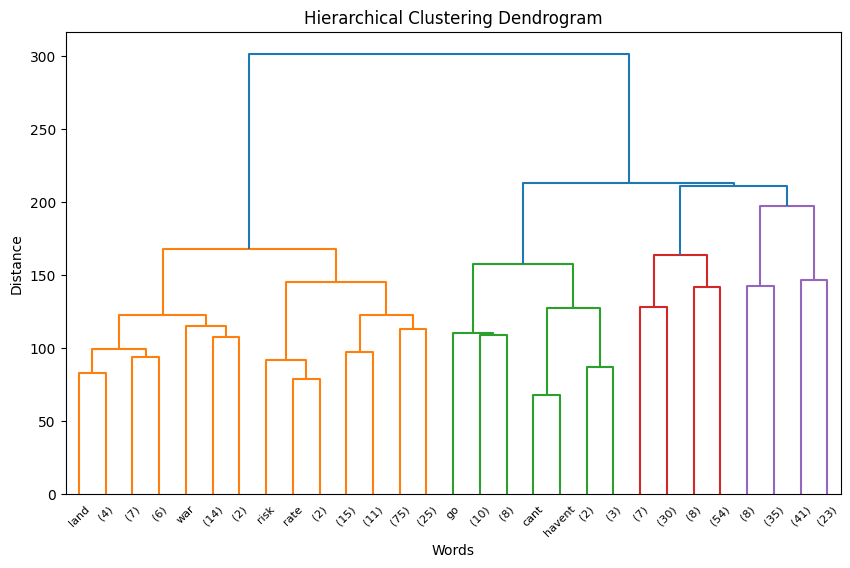

In [1262]:
import pandas as pd
import spacy
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt


Z = linkage(word_vectors.values, method='ward')

plt.figure(figsize=(10,6))
dendrogram(Z, p = 4, truncate_mode = "level", orientation='top', labels = popular_words, leaf_font_size = 8)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Words')
plt.ylabel('Distance')
plt.show()

In [1263]:
from scipy.cluster.hierarchy import fcluster

cluster_labels = fcluster(Z, t = 75,  criterion="distance")

clusters = {}
for word, label in zip(popular_words, cluster_labels):
    if label not in clusters:
        clusters[label] = [word]
    else:
        clusters[label].append(word)

for label, words in clusters.items():
    print(f"Cluster {label}: {', '.join(words)}")

Cluster 68: game, play, player, playing
Cluster 57: puzzle, pirate, horror, zomby, zombie, pawn, wolf, franchise, coop, nightmare, pve, limbo, gamei, fable, clue, eargasm, glado, chill, cannibal, hacker
Cluster 21: experience, community, work, environment, resource, workshop, focus, knowledge, research, project, practice, learning
Cluster 75: gameplay, gamer, gaming, rng, bonus, replay, cue
Cluster 99: way, pace
Cluster 97: hour, week, night
Cluster 12: price, cost
Cluster 47: person, friend, boss, child, woman, family, partner
Cluster 48: love, choice, voice, wish, reward, hope, enjoyment, pleasure, praise
Cluster 62: character, hero, genre, plot, figure, episode, cutscene, lore, chapter, legend, protagonist, narrator, backstory
Cluster 1: world, city, country, nation
Cluster 54: fun
Cluster 19: level, point, number, class, rating
Cluster 72: review, note, view, guide
Cluster 76: graphic, visual, video, pixel
Cluster 18: content, quality, value, product
Cluster 52: lot
Cluster 50: lif

In [1267]:
def words_to_list(words_string):
    return words_string.split()

clusters_df = pd.read_csv('clusters.csv', converters={'Words': words_to_list})
clusters_df

,Cluster,Words
0,68,"[game, play, player, playing]"
1,57,"[puzzle, pirate, horror, zomby, zombie, pawn, ..."
2,21,"[experience, community, work, environment, res..."
3,75,"[gameplay, gamer, gaming, rng, bonus, replay, ..."
4,99,"[way, pace]"
...,...,...
98,13,[rate]
99,73,[log]
100,44,[role]
101,74,[key]
